# Exoplanets HW 2
Jake Lustig-Yaeger and David Fleming solution

---

Make sure ExoJulia is in our path.

In [36]:
push!(LOAD_PATH, "../../../ExoJulia/")

4-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "../../../ExoJulia/"                                                                
 "../../../ExoJulia/"                                                                

Make sure to include relevant packages and our code!

In [110]:
using ExoJulia
using PyPlot
using LsqFit

In [121]:
include("utils.jl")
include("orbital_utils.jl")
include("rv.jl")
include("rv_fitting.jl")

solve_rv (generic function with 1 method)

### Read-in Mystery RV data

In [39]:
numbers = readdlm("mystery_planet.txt");

In [40]:
time = numbers[:,1];
rv = numbers[:,2];
err = numbers[:,end];

Plot it to see if there's any trend.

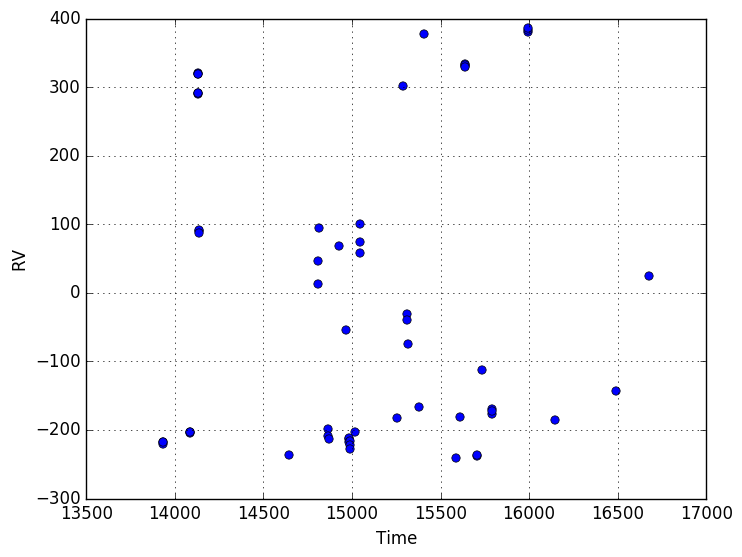

In [220]:
plot(time, rv, "o")
xlabel("Time")
ylabel("RV")
grid("on")

## Period Fitting

There's no obvious trend in the data, so we'll see if we can back our way into a period.  Using Eric's suggestion for data with small error bars, loop over a grid of periods and sort the RV points by phase.  Then, take the sum of squares of differences of successive points and find the period that corresponds to the smallest sum.  This method will be a useful means to guess the period later on for more robust fitting.

### Agol Method

In [114]:
periods = linspace(1.0, 365.0, 2000)

linspace(1.0,365.0,2000)

In [115]:
p = collect(periods);

In [116]:
@time best_period = agol_periodogram(numbers, p)
# [time rv err]

116.62781390695348

0.052119 seconds (60.01 k allocations: 17.414 MB, 6.09% gc time)


## Plot the best period!

Plot the data phase folded by the best period.

In [117]:
phase = mod(time,best_period)
data = [phase rv]
data = fastsortrows(data, [1])

59x2 Array{Float64,2}:
   7.77147   301.1
   8.84351   333.8
   8.84407   330.3
   8.84466   332.3
   8.84526   329.7
  10.8648    377.3
  15.0141    379.9
  15.0165    382.7
  15.0198    386.1
  18.1569    321.0
  18.1576    318.4
  18.1582    319.2
  19.151     290.6
   ⋮              
  95.3319   -182.2
  95.681    -180.8
  97.5085   -167.0
 103.813    -113.1
 112.057      12.3
 114.038      24.3
 114.062      46.7
 114.373      58.4
 115.272      68.3
 115.383      74.7
 116.065      95.0
 116.416     100.2

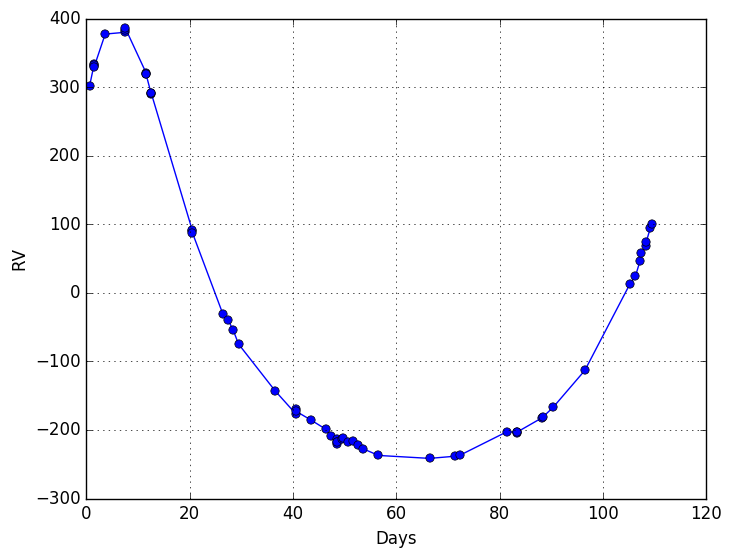

In [218]:
plot(data[:,1], data[:,2], "o-")
xlabel("Days")
ylabel("RV")
grid("on")

# 2: Fitting data from the mystery planet!
Our functions used to fit the RV data are all contained in `orbital_utils.jl`, `rv.jl`, `rv_fitting.jl` and `utils.jl`.  In the cells below, we'll show how they're used with our master wrapper function to recover the correct parameters.  Our solution implements the Wright & Howard 2009 linearlized radial velocity method to estimate the RV parameters while minimizing over P, e, and t$_p$.  For P, we'll use the Agol periodogram method to get a good first guess for quick convergence.  If you don't want wade though our `*.jl` files to see our implimentation, check out `hw2_rv.ipynb` for a more organized look at our code.

Below, the `solve_rv` function will compute the Agol periodogram best fit period (see below!) to use as a first guess, then will pick a random value for both eccentricity and time of periastron passage from [0,1) and min(time) to max(time), respectively.  Note: In order for this function to work, the data (time, rv and err) must be global variables.  This suits itself to working well in notebooks or extended scripts where they are currently stored in memory.

Also, sometimes this cell needs to be reran as it spits out the correct answers, but prints them all negative for reasons unknown.

In [140]:
P_best, e_best, tp_best = solve_rv([time rv err])

3-element Array{Float64,1}:
   116.682   
     0.399921
 15058.2     

In [141]:
print("Best fit period: $P_best days.\n")
print("Best fit eccentricity: $e_best.\n")
print("Best fit time of periastron passage: $tp_best days.")

Best fit period: 116.68232787247975 days.
Best fit eccentricity: 0.39992077704456125.
Best fit time of periastron passage: 15058.237809881535 days.

### Now, let's compute $\gamma$ and K.

First, we'll run our forward model on the data with the best fit parameters to compute the best RV and model parameters (h, c and v0).  Then, we'll use those best fit parameters to calculate the remaining two before printing them to the screen.

In [196]:
rv_best, B = rv_forward(P_best, e_best, tp_best, time, rv, err); # B = [h, c, v0, d]
h_best = B[1]
c_best = B[2]
v0_best = B[3]

print("Best fit h = $h_best.\n")
print("Best fit c = $c_best.\n")
print("Best fit v0 = $v0_best.\n")

Best fit h = -315.79409582096895.
Best fit c = 3.773277860323086.
Best fit v0 = 73.89431166732737.


In [197]:
function fit_to_physical(ecc::Float64,h::Float64,c::Float64,v0::Float64)
    w = atan2(-c,h)
    K = h / cos(w)
    gamma = v0 - K*ecc*cos(w)
    
    return K, gamma
end

fit_to_physical (generic function with 2 methods)

In [198]:
K_best, gamma_best = fit_to_physical(e_best,h_best,c_best,v0_best)

print("Best fit K = $K_best.\n")
print("Best fit gamma = $gamma_best.\n")

Best fit K = 315.8166375940231.
Best fit gamma = 200.18693185413392.


### To see how well our fit matches the data, we'll phase fold the data over the best fit period and then overplot our model's predicted RV curve.

First, we'll have to phase fold the best rv model which is also evaluated on the same time array as the observations.

In [213]:
phase_best = mod(time,P_best);
data_best = [phase_best reshape(rv_best, length(phase_best))];
data_best = fastsortrows(data_best, [1]);

phase = mod(time,P_best);
data = [phase rv];
data = fastsortrows(data, [1]);

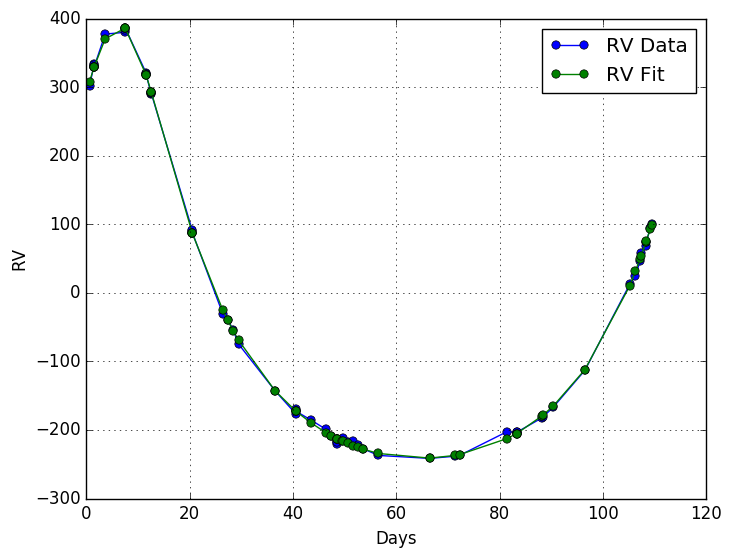

In [222]:
plot(data[:,1], data[:,2], "o-", label="RV Data")
plot(data_best[:,1], data_best[:,2], "o-", label="RV Fit")
xlabel("Days")
ylabel("RV")
legend(loc="upper right")
grid("on")

With the correct fit to the RV data, we can now get an estimate for P, e, t$_p$, $\gamma$ and K.  The calculations are done below.

# 3. Write julia code to compute the f & g functions.

---

Our implementation for the f & g functions (and their time derivatives!) are located in `orbital_utils.jl`.